In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q drive/MyDrive/'Colab Notebooks'/name.zip

In [62]:
!unzip -q drive/MyDrive/'Colab Notebooks'/beeds.zip

In [64]:
mkdir beeds && mv *.jpg beeds/

In [5]:
# !ls Датасет/'Только собака'/'ТОЛЬКО СОБАКА -разноцветный - короткий хвост'
!ls "/content/Датасет/Только собака/ТОЛЬКО СОБАКА -разноцветный - короткий хвост"

130.jpg   2380.jpg  2571.jpg  6169.jpg	645.jpg   6567.jpg  6640.jpg  6811.jpg
135.png   2413.jpg  337.png   6176.jpg	6461.jpg  6568.jpg  6652.jpg  6812.jpg
138.jpg   2417.jpg  345.png   6209.jpg	6462.jpg  6570.jpg  6653.jpg  6831.jpg
166.png   2435.jpg  364.jpg   624.jpg	6463.jpg  6571.jpg  6657.jpg  6833.jpg
169.png   2438.jpg  420.jpg   6250.jpg	6476.jpg  6576.jpg  6659.jpg  6844.jpg
175.png   2461.jpg  421.jpg   6251.jpg	6490.jpg  6577.jpg  6669.jpg  6857.jpg
205.jpg   2465.jpg  453.png   6275.jpg	6492.jpg  6585.jpg  6670.jpg  6862.jpg
2135.jpg  2468.jpg  459.jpg   6277.jpg	649.jpg   6590.jpg  668.jpg   6869.jpg
2264.jpg  2476.jpg  548.jpg   6279.jpg	6502.jpg  6591.jpg  6700.jpg  6871.jpg
2265.jpg  2483.jpg  555.png   6281.jpg	6507.jpg  6594.jpg  6711.jpg  6872.jpg
2270.jpg  2488.jpg  564.jpg   6295.jpg	6511.jpg  6598.jpg  6720.jpg  6873.jpg
2303.jpg  2493.jpg  596.jpg   6296.jpg	6513.jpg  6607.jpg  6733.jpg  6876.jpg
2305.jpg  2494.jpg  6015.jpg  6307.jpg	6515.jpg  6609.jpg  6739.j

In [10]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [11]:
indices_animal_detection = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
]

In [ ]:
class ColorDetector():
    def __init__(self):
        pass
    def __call__(self):
        pass

In [ ]:
class Mock():
    def __init__(self):
        pass
    def __call__(self, x):
        return torch.ones((x.size()[0], 2))

In [ ]:
class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
        ):
        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.animals = ["cat", "dog"]
        self.indices_cat_dog_classification = indices_cat_dog_classification
        # a person is huge so detector says the right answers
        self.indices_animal_detection  = indices_animal_detection

    def __get_detection_predictions(self, picture):
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determine class of an animal
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label
    
    def __get_cropped_image(self, picture, coordinates):
        '''
            picture is a torch.Tensor
            coordinates is a torch.Tensor
        '''
        coordinates = coordinates.detach().numpy().astype(dtype=int)
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]

        return torchvision.transforms.functional.crop(picture, y, x, h, w)

    def __get_dog_features(self, dog_image):
        return [
                self.model_classification_dog_color(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_tail(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_breed(dog_image).argmax(axis=1)[0].item(),
        ]

    def __converter_dog_features(self, data):
        raise NotImplementedError()

    def get_features(self, picture_numpy):
        features = []
        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)
        
        boxes, labels = self.__get_detection_predictions(picture)
        for box, label in zip(boxes, labels):
            # if it is an animal
            if label in self.indices_animal_detection:
                cropped_image = self.__get_cropped_image(picture, box)
                pred = self.__get_classification_animal_predictions(
                    cropped_image
                )
                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    features.append(self.__get_dog_features(cropped_image))

        return features


In [ ]:
find_lost_animals = FindLostAnimal(model_detection, 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   animal_indices_detector, 
                                   [0])

In [ ]:
find_lost_animals.get_features(picture)

[[0, 0, 0]]

In [ ]:
inst_classes.

In [7]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [58]:
!mkdir tails && mkdir tails/short && mkdir tails/long

In [133]:
!rm /content/tails/*.jpg

In [140]:
175 + 143

318

In [143]:
212 + 243

455

In [142]:
!ls "/content/Датасет/Только собака/ТОЛЬКО СОБАКАЯ СВЕТЛЫЙ КОРОТКИЙ" | wc -w

243


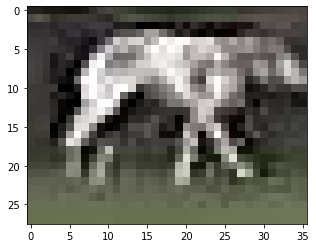

KeyboardInterrupt: ignored

In [136]:
from IPython.display import clear_output
from time import sleep

start = 100

def generate_dataset_human(model_detection, path, interesting_indices, to_dir):
    '''
        model_detection
        path - path to directory
        interesting_indices - indices from model_detection to show
        to_dir - list of directories to move appropriate files
    '''
    cnt = 0 + start
    process = os.popen("ls " + f'"{path}"')
    files = process.read().split()
    model_detection.eval()
    for file in files:
        # image = Image.open(os.path.join(path, file))
        image = Image.open(path + '/' + file)
        image = np.asarray(image)
        # BAD BAD BAD
        if image.shape[-1] > 3:
            continue
        image_torch = torch.from_numpy(image) / 256
        image_torch = image_torch.permute(2, 0, 1).unsqueeze_(0)
        pred = model_detection(image_torch)[0]

        labels = []
        boxes = []
        array_of_shapes = []
        for i in range(len(pred['labels'])):
            if pred['labels'][i].item() in interesting_indices:
                labels.append(pred['labels'][i].item())
                boxes.append(pred['boxes'][i])
                array_of_shapes.append((boxes[-1][2] - boxes[-1][0]) * 
                                       (boxes[-1][3] - boxes[-1][1]))
        if (len(array_of_shapes) == 0):
            continue
    
        max_index = np.argmax(array_of_shapes)
        label = labels[max_index]
        box = boxes[max_index]
        cnt += 1
        print(cnt, file)
        clear_output(wait=True)
        cropped_image = get_cropped_image(image_torch, box, expand_coeff=1.2)
        cropped_image_numpy = cropped_image[0].permute(1, 2, 0).\
        detach().numpy() * 256
        cropped_image_numpy = cropped_image_numpy.astype(dtype=np.uint8)
        plt.imshow(cropped_image_numpy)
        plt.show()
        sleep(1)
        state = int(input())
        if state != -1:
            image_PIL = Image.fromarray(cropped_image_numpy)
            image_PIL.save(to_dir[state] + str(cnt) + ".jpg")

generate_dataset_human(model_detection, 
                       "/content/Датасет/Только собака/ТОЛЬКО СОБАКА СВЕТЛЫЙ ДЛИННЫЙ", 
                       indices_animal_detection, 
                       ["tails/short/", "tails/long/"])

In [126]:
predicted[0]["labels"]

tensor([ 3,  3,  3,  1,  3, 18,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        18,  3,  3,  3,  8,  3,  3,  4, 27,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  8,  3,  3,  3,  3,  3, 31,  8,  3,  3, 27,  3,  3,  8,
         4,  2,  1])

In [115]:
image = Image.open('/content/Датасет/Хозяин и собака/140.jpg')

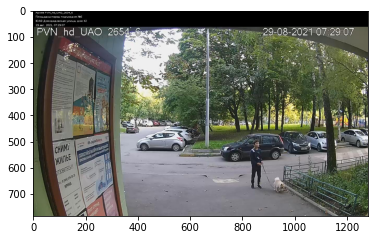

In [116]:
picture = np.asarray(image)
plt.imshow(picture)
plt.show()

In [117]:
picture_torch = torch.from_numpy(picture)
picture_torch = picture_torch.permute(2, 0, 1) / 256

In [118]:
picture_torch.unsqueeze_(0)
print(picture_torch.shape)

torch.Size([1, 3, 784, 1280])


In [119]:
model_detection.eval()
predicted = model_detection(picture_torch)

In [ ]:
predicted[0]

{'boxes': tensor([[932.1390, 310.3073, 997.6531, 351.7474],
         [394.5561, 222.7341, 423.1493, 251.1258],
         [395.9259, 220.4958, 414.7158, 245.4420],
         [396.5888, 223.3082, 419.1169, 246.8962],
         [402.4055, 225.7819, 420.8284, 247.1655],
         [931.9644, 310.4192, 992.2725, 349.9368],
         [386.6541, 172.9644, 398.8870, 198.8327],
         [396.6113, 223.3146, 418.4376, 247.4306],
         [382.7404, 161.7232, 405.3268, 210.6008],
         [334.1688,  91.1502, 354.9084, 104.9097]], grad_fn=<StackBackward>),
 'labels': tensor([18, 15, 15, 18, 15, 17,  1, 21,  1, 37]),
 'scores': tensor([0.8617, 0.2316, 0.1624, 0.0932, 0.0695, 0.0649, 0.0602, 0.0593, 0.0528,
         0.0509], grad_fn=<IndexBackward>)}

In [120]:
boxes = predicted[0]['boxes']
labels = predicted[0]['labels']

In [ ]:
inst_classes.index('person')

1

In [ ]:
a = (labels == 18).nonzero().item()
print (a)

4


In [81]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()


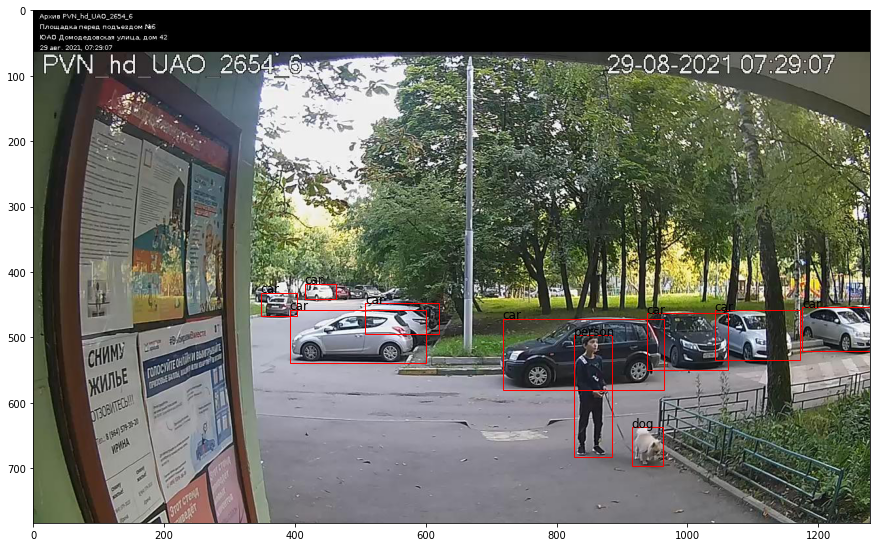

In [122]:
draw_pic_with_rect(picture, boxes, labels, 10)

In [89]:
def get_cropped_image(picture, coordinates, expand_coeff=2.0):
    '''
        picture: torch.Tensor
        coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
    '''
    x = coordinates[0]
    y = coordinates[1]
    w = coordinates[2] - coordinates[0]
    h = coordinates[3] - coordinates[1]
    w_expanded = int(w * expand_coeff)
    h_expanded = int(h * expand_coeff)
    x_expanded = int(x - (w_expanded - w) / 2.0)
    y_expanded = int(y - (h_expanded - h) / 2.0)

    return torchvision.transforms.functional.crop(
        picture, 
        int(y_expanded), 
        int(x_expanded), 
        int(h_expanded), 
        int(w_expanded),
    )

Нижняя по вертикали, левая по горизонтали

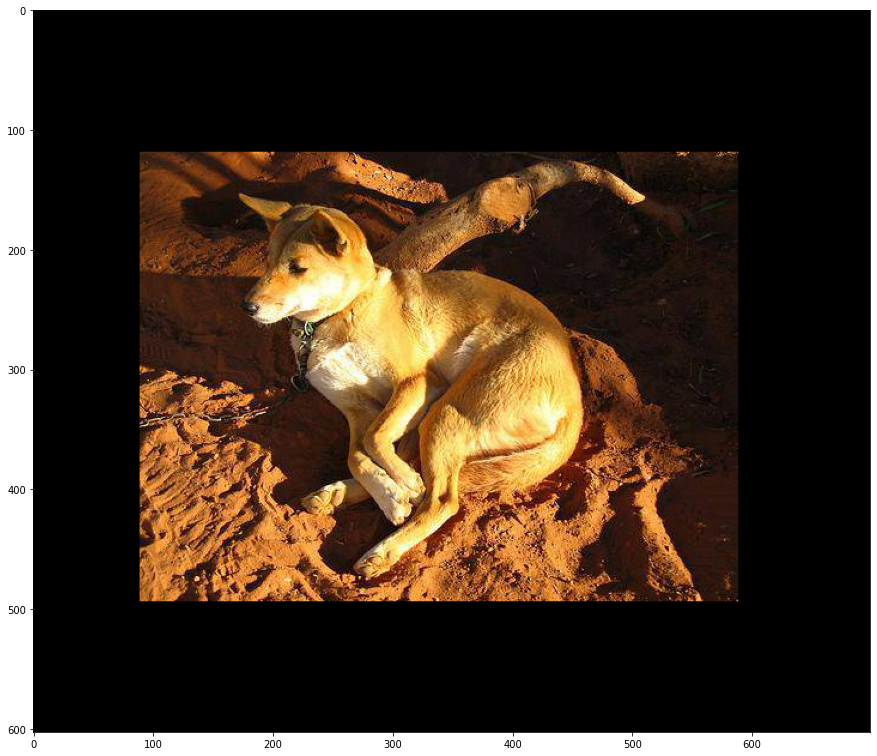

In [91]:
# plt.imshow(fragment_numpy.astype(int))
draw_pic_with_rect(get_cropped_image(picture_torch, boxes[0], 2.0), [], [])

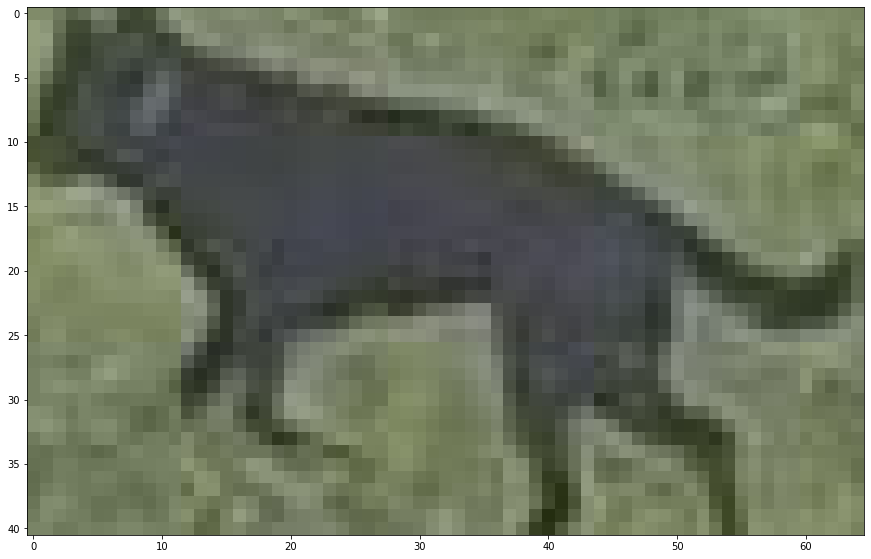

In [ ]:
# plt.imshow(fragment_numpy.astype(int))
draw_pic_with_rect(get_cropped_image(picture_torch, boxes[0]), [], [])

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-10-11 18:47:11--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-10-11 18:47:11 (64.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
class ModelClassification(torch.nn.Module):
    def __init__(self, network, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network = network
        self.transforms = torchvision.\
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    def predict_preprocessed(self, x):
        return self.network(x)

    def get_label(self, pred, categories, top=5):
        top_prob, top_catid = torch.topk(pred, top)
        top_prob = top_prob[0]
        top_catid = top_catid[0]
        for i in range(top):
            print(categories[top_catid[i]])

    def predict(self, x):
        x = self.transforms(x)
        return self.predict_preprocessed(x)

In [ ]:
model_classification = ModelClassification(torchvision.models.resnet34(pretrained = True))
model_classification.eval()
picture = get_cropped_image(picture_torch, boxes[0])
preds = model_classification.predict(picture.unsqueeze(0))

In [ ]:
model_classification.get_label(preds, categories)

lab coat 8.098236083984375
crutch 7.842294692993164
croquet ball 6.9661126136779785
jean 6.679392337799072
neck brace 6.643121242523193


In [ ]:
model_segmetation = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
cropped_image = get_cropped_image(picture_torch, boxes[0])

In [ ]:
print(cropped_image.shape)

torch.Size([1, 3, 41, 65])


In [ ]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_classes.index("dog")

12

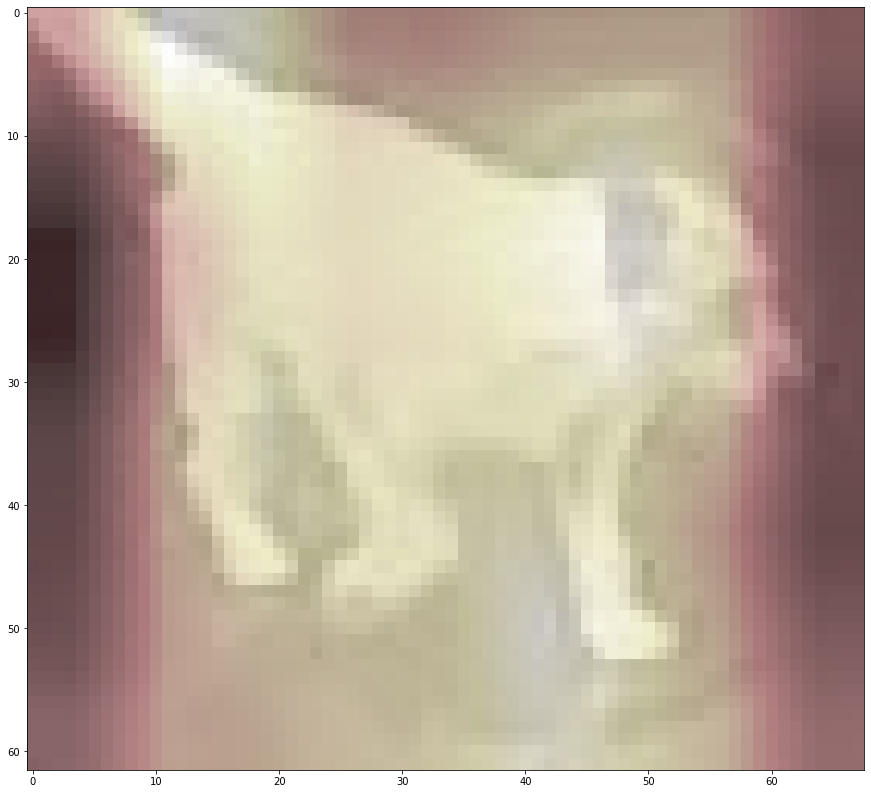

In [ ]:
def draw_segmentation(model_segmentation, picture):


    transforms = torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                  std=[0.229, 0.224, 0.225])
    transformed_picture = transforms(picture)
    pred = model_segmetation(transformed_picture)["out"]
    plt.figure(figsize=(15, 15))
    plt.imshow((picture[0].detach().permute(1, 2, 0).numpy() * 256).astype(int))
    predicted_picture = torch.nn.functional.softmax(pred[0][12], dim=1)
    plt.imshow(predicted_picture.detach().numpy(), cmap="pink", alpha=0.7)
    plt.show()

draw_segmentation(model_segmetation, cropped_image)

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb


In [ ]:
def segment(net, img):
  net.eval()
  plt.figure(figsize=(15,15))
  plt.imshow(img.permute(1, 2, 0).detach().numpy()); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = torchvision.transforms.Compose([
                    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.figure(figsize=(15,15))
  plt.imshow(rgb); plt.axis('off'); plt.show()


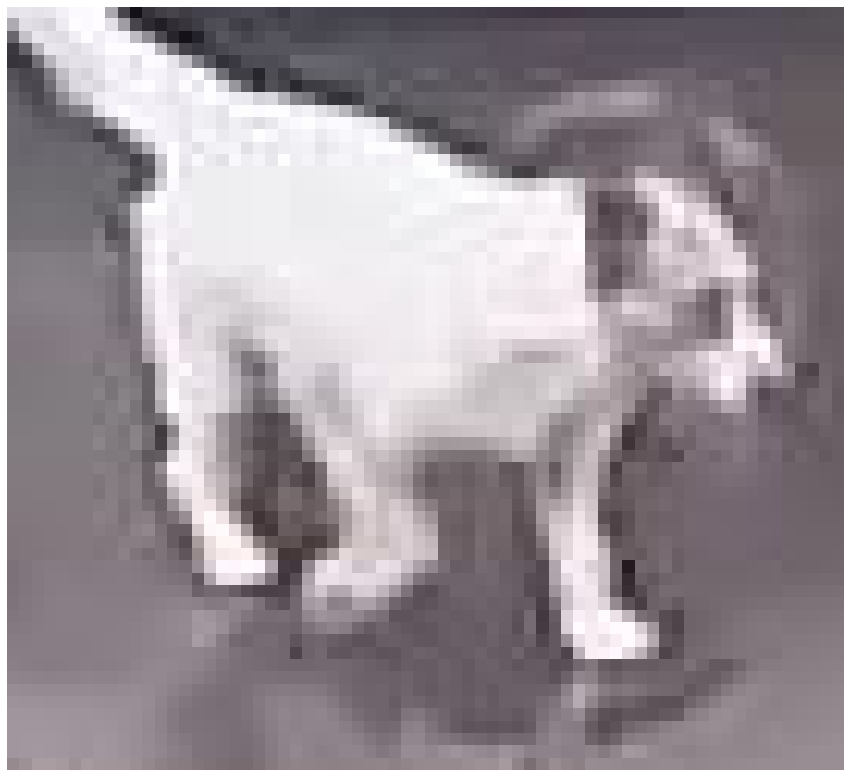

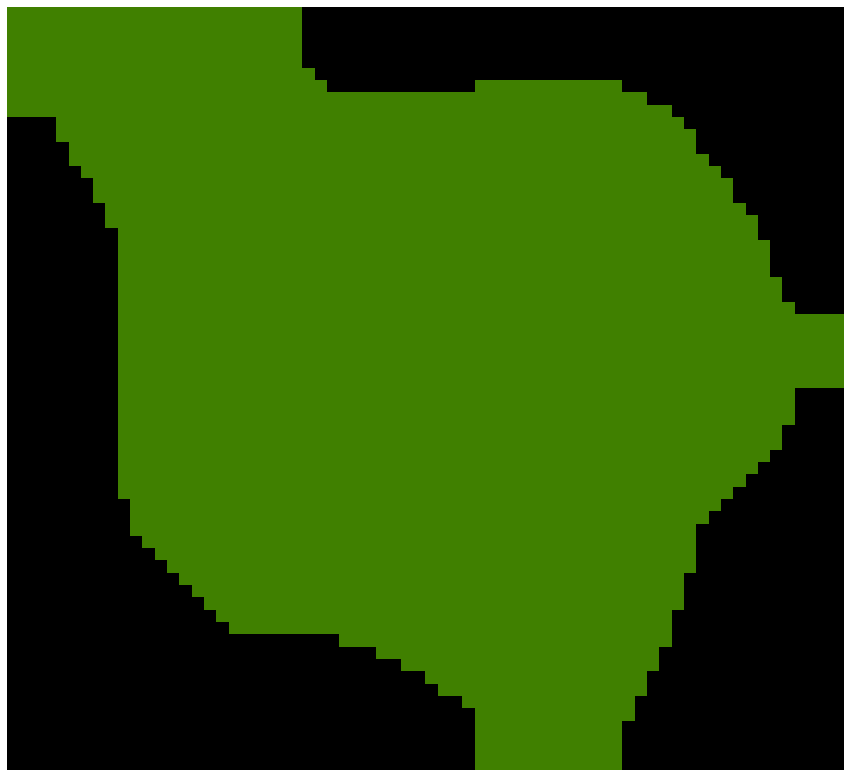

In [ ]:
segment(model_segmetation, cropped_image[0])

In [ ]:
def gradient_img(img):
    img = img.squeeze(0)
    ten=torch.unbind(img)
    x=ten[0].unsqueeze(0).unsqueeze(0)
    
    a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    conv1=torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    conv1.weight=torch.nn.Parameter(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0))
    G_x=conv1(torch.autograd.Variable(x)).data.view(1,x.shape[2],x.shape[3])

    b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    conv2=torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
    conv2.weight=torch.nn.Parameter(torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0))
    G_y=conv2(torch.autograd.Variable(x)).data.view(1,x.shape[2],x.shape[3])

    G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
    return G

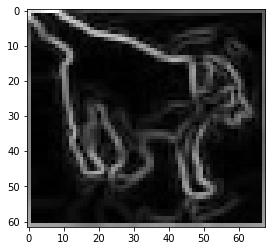

In [ ]:
plt.imshow(gradient_img(cropped_image)[0].detach().numpy() * 256, cmap='gray')
plt.show()

In [ ]:
cropped_image.shape

torch.Size([1, 3, 62, 68])

In [ ]:
def get_dog_color(image, THRESHOLD=1./8.):
    h = int(THRESHOLD * image.shape[1])
    w = int(THRESHOLD * image.shape[2])
    cropped_image = torchvision.transforms.functional.crop(image, 
    image.shape[1] // 2 - h // 2, image.shape[2] // 2 - w // 2, h, w)
    color = [0] * cropped_image.shape[0]
    for channel in range(cropped_image.shape[0]):
        color[channel] = cropped_image[channel].mean().item() * 256
    return color

get_dog_color(cropped_image[0])

[62.875, 64.375, 64.625]